# Document Image Classification

### 1.1 Description

The RVL-CDIP (Ryerson Vision Lab Complex Document Information Processing) dataset consists of 400,000 grayscale images in 16 classes, with 25,000 images per class. There are 320,000 training images, 40,000 validation images, and 40,000 test images. The images are sized so their largest dimension does not exceed 1000 pixels.

Here are the classes in the dataset, and an example from each:

### 1.2 Problem Statemtent

Detection of different types of Document images and classify them in different classes like letter, form, email, handwritten, advertisement, scientific report, scientific publication, specification, file folder, news article, budget, invoice, presentation, questionnaire, resume, memo. So It is a Multiclass Classification Problem or we can call it a Computer Vision task.

### 1.3 Data Description

The label files list the images and their categories in the following format:

path/to/the/image.tif category
where the categories are numbered 0 to 15, in the following order:

    0.letter                                    1.form                                      2.email                            3.handwritten                               4.advertisement                             5.scientific report                6.scientific publication                    7.specification                             8.file folder
    9.news article                              10.budget                                   11.invoice
    12.presentation                             13.questionnaire                            14.resume
    15.memo

### 1.4 Usage

This dataset is a subset of the IIT-CDIP Test Collection 1.0 [1], which is publicly available here. The file structure of this dataset is the same as in the IIT collection, so it is possible to refer to that dataset for OCR and additional metadata. The IIT-CDIP dataset is itself a subset of the Legacy Tobacco Document Library [2].

### 1.5 Real-world/Business objectives and constraints

1. The cost of a mis-classification can be high.
2. No strict latency concerns.
3. Computationally Expensive

### Importing Libraries

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from pathlib import Path
import shutil

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Loading DataSet

In [3]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c datathonindoml-2022

Saving kaggle.json to kaggle.json
100% 1.51G/1.51G [01:08<00:00, 38.6MB/s]
100% 1.51G/1.51G [01:08<00:00, 23.8MB/s]


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [5]:
local_zip = '/content/datathonindoml-2022.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [6]:
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train/train')
valid_dir = os.path.join(base_dir, 'validation/validation')

### Preprocessing and Data Generation

In [7]:
classes = {
    0:'memo',
    1:'form',
    2:'email',
    3:'handwritten',
    4:'advertisement',
    5:'scientific_report',
    6:'scientific_publication',
    7:'specification',
    8:'file_folder',
    9:'news_article',
    10:'budget',
    11:'invoice',
    12:'presentation',
    13:'questionaire',
    14:'resume',
    15:'letter'
}

In [8]:
for (key,value) in classes.items():
  path = os.path.join(train_dir, value)
  os.mkdir(path)

In [9]:
train_labels = pd.read_csv(base_dir+'/train_labels.csv')
train_labels.head(5)

,id,label
0,0,1
1,1,13
2,2,13
3,3,14
4,4,6


In [10]:
def push_to_dir(key, value, dir):
  file_ids = train_labels[train_labels['label']==key]['id'].values
  for file_id in file_ids:
    shutil.move(os.path.join(dir,str(file_id))+'.tif', os.path.join(os.path.join(dir,value),str(file_id))+'.tif')

for key,value in classes.items():
  push_to_dir(key,value,train_dir)

In [11]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        subset='training')

Found 11207 images belonging to 16 classes.


In [12]:
valid_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        subset='validation')

Found 4793 images belonging to 16 classes.


### Visualizing Dataset


Class Type = letter, filename = 11524.tif


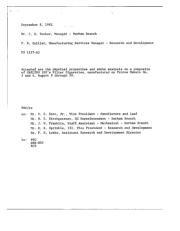


Class Type = news_article, filename = 12847.tif


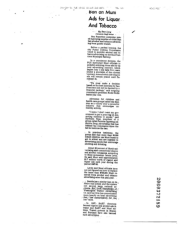


Class Type = questionaire, filename = 8653.tif


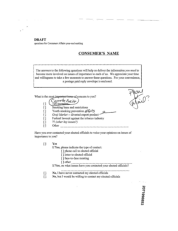


Class Type = scientific_publication, filename = 11340.tif


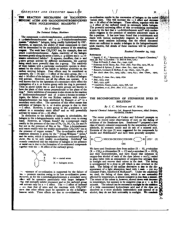


Class Type = email, filename = 9984.tif


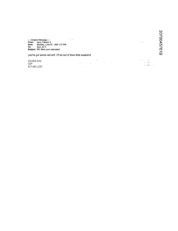


Class Type = scientific_report, filename = 10459.tif


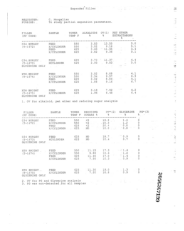


Class Type = presentation, filename = 13302.tif


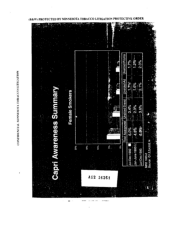


Class Type = file_folder, filename = 4009.tif


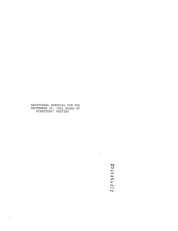


Class Type = form, filename = 9561.tif


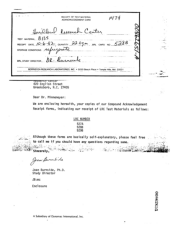


Class Type = resume, filename = 7635.tif


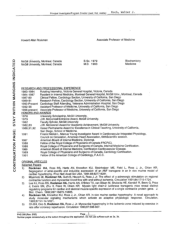


Class Type = invoice, filename = 15728.tif


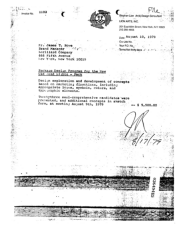


Class Type = budget, filename = 9520.tif


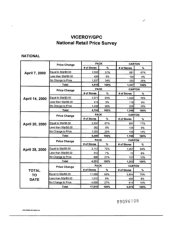


Class Type = memo, filename = 4615.tif


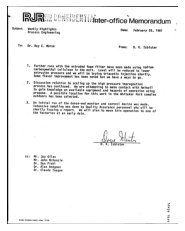


Class Type = advertisement, filename = 14681.tif


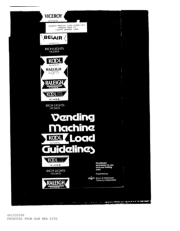


Class Type = specification, filename = 625.tif


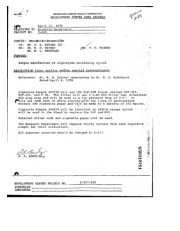


Class Type = handwritten, filename = 13089.tif


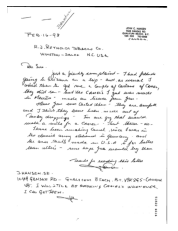

In [13]:
train_classes_dir = os.listdir(train_dir)

for label in train_classes_dir:
  i = 1
  path = os.path.join(train_dir, label)
  fname = os.listdir(path)[0]
  image = cv2.imread(os.path.join(path,fname))
  print(f'\nClass Type = {label}, filename = {fname}')
  plt.axis('off')
  plt.imshow(image)
  plt.show()

In [14]:
def visualise_train(history):
  sns.set_style("darkgrid")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)



  #Train and validation loss
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epoch #')
  plt.ylabel('loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Baseline Models

#### a. GoogleNet

In [21]:
def GoogleNet(classes):
  from keras.applications.inception_v3 import InceptionV3
  base_model = InceptionV3(input_shape = (224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(name='GlobalAvgPooling_Layer'),
    tf.keras.layers.Dropout(0.4, name='Dropout_Layer'),
    tf.keras.layers.Dense(classes, activation='softmax', name='Output_Layer')
  ])

  model.summary()

  model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001, momentum=0.9), metrics = ['accuracy'])
  return model

In [22]:
googlenet_model = GoogleNet(classes = 16)

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 GlobalAvgPooling_Layer (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 Dropout_Layer (Dropout)     (None, 2048)              0         
                                                                 
 Output_Layer (Dense)        (None, 16)                32784     
                                                                 
Total params: 21,835,568
Trainable params: 32,784
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
googlenet_history = googlenet_model.fit(train_generator, epochs=20, validation_data = valid_generator,verbose = 1)

Epoch 1/20
351/351 [==============================] - 73s 193ms/step - loss: 2.7843 - accuracy: 0.1283 - val_loss: 2.4060 - val_accuracy: 0.2871
Epoch 2/20
351/351 [==============================] - 66s 187ms/step - loss: 2.4304 - accuracy: 0.2402 - val_loss: 2.1672 - val_accuracy: 0.3645
Epoch 3/20
351/351 [==============================] - 65s 185ms/step - loss: 2.2334 - accuracy: 0.3062 - val_loss: 2.0295 - val_accuracy: 0.4071
Epoch 4/20
351/351 [==============================] - 66s 188ms/step - loss: 2.1189 - accuracy: 0.3395 - val_loss: 1.9426 - val_accuracy: 0.4340
Epoch 5/20
351/351 [==============================] - 65s 186ms/step - loss: 2.0433 - accuracy: 0.3661 - val_loss: 1.8820 - val_accuracy: 0.4423
Epoch 6/20
351/351 [==============================] - 65s 185ms/step - loss: 1.9849 - accuracy: 0.3827 - val_loss: 1.8345 - val_accuracy: 0.4615
Epoch 7/20
351/351 [==============================] - 65s 184ms/step - loss: 1.9481 - accuracy: 0.3940 - val_loss: 1.7984 - val_ac

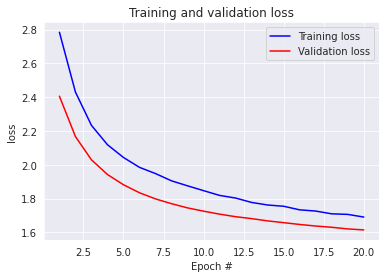

In [24]:
visualise_train(googlenet_history)

#### b. ResNet50

In [ ]:
def ResNet(classes):
  from keras.applications.resnet_v2 import ResNet50V2
  base_model = ResNet50V2(input_shape = (224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(name='GlobalAvgPooling_Layer'),
    tf.keras.layers.Dropout(0.4, name='Dropout_Layer'),
    tf.keras.layers.Dense(classes, activation='softmax', name='Output_Layer')
  ])

  model.summary()

  model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001, momentum=0.9), metrics = ['accuracy'])
  return model

In [ ]:
resnet_model = ResNet(classes = 16)

94683136/94668760 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 GlobalAvgPooling_Layer (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 Dropout_Layer (Dropout)     (None, 2048)              0         
                                                                 
 Output_Layer (Dense)        (None, 16)                32784     
                                                                 
Total params: 23,597,584
Trainable params: 32,784
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(train_generator, epochs=20, validation_data = valid_generator, verbose = 1)

#### c. VGG16

In [17]:
def VGG(classes):
  from keras.applications.vgg16 import VGG16
  base_model = VGG16(input_shape = (224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 6, activation = 'relu'),
    tf.keras.layers.GlobalAveragePooling2D(name='GlobalAvgPooling_Layer'),
    tf.keras.layers.Dropout(0.4, name='Dropout_Layer'),
    tf.keras.layers.Dense(classes, activation='softmax', name='Output_Layer')
  ])

  model.summary()

  model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001, momentum=0.9), metrics = ['accuracy'])
  return model

In [18]:
vgg_model = VGG(classes = 16)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 32)          589856    
                                                                 
 GlobalAvgPooling_Layer (Glo  (None, 32)               0         
 balAveragePooling2D)                                            
                                                                 
 Dropout_Layer (Dropout)     (None, 32)                0         
                                                                 
 Output_Layer (Dense)        (None, 16)                528       
                                                                 
Total params: 15,305,072
Trainable params: 590,384
Non-trainable params: 14,714,688
____________________________________

In [19]:
vgg_history = vgg_model.fit(train_generator, epochs=60, validation_data = valid_generator,verbose = 1)

Epoch 1/60
351/351 [==============================] - 90s 219ms/step - loss: 2.7403 - accuracy: 0.0792 - val_loss: 2.6750 - val_accuracy: 0.1246
Epoch 2/60
351/351 [==============================] - 76s 215ms/step - loss: 2.6349 - accuracy: 0.1360 - val_loss: 2.5143 - val_accuracy: 0.2940
Epoch 3/60
351/351 [==============================] - 77s 220ms/step - loss: 2.5196 - accuracy: 0.1903 - val_loss: 2.3921 - val_accuracy: 0.3616
Epoch 4/60
351/351 [==============================] - 78s 222ms/step - loss: 2.4294 - accuracy: 0.2266 - val_loss: 2.2973 - val_accuracy: 0.3985
Epoch 5/60
351/351 [==============================] - 79s 224ms/step - loss: 2.3633 - accuracy: 0.2544 - val_loss: 2.2154 - val_accuracy: 0.4192
Epoch 6/60
351/351 [==============================] - 79s 225ms/step - loss: 2.2960 - accuracy: 0.2818 - val_loss: 2.1209 - val_accuracy: 0.4461
Epoch 7/60
351/351 [==============================] - 80s 229ms/step - loss: 2.2396 - accuracy: 0.3068 - val_loss: 2.0635 - val_ac

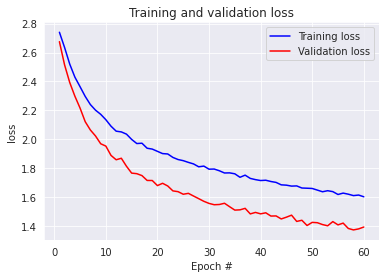

In [20]:
visualise_train(vgg_history)